In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## Loading Dataset 

In [2]:
# Load dataset
df = pd.read_csv("C:/Users/Prasanth\Downloads/Final_Dataset_Cleaned.csv")

# Drop unnecessary ID columns
df.drop(columns=['country_id', 'country_code', 'cause_id'], inplace=True)

country_series = df['country_name']

# One-hot encode cause_name → disease_*
df = pd.get_dummies(df, columns=['cause_name'], prefix='disease', drop_first=True)

df['country_name'] = country_series

# Dropping Target Variable

X = df.drop(columns=['mortality_rate'])
y = df['mortality_rate']

# Train Test Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Target encoding for country_name

global_mean = y_train.mean()
smoothing = 10
kf = KFold(n_splits=5, shuffle=True, random_state=42)
country_te = pd.Series(index=X_train.index, dtype=float)

for train_idx, valid_idx in kf.split(X_train):
    fold_X = X_train.iloc[train_idx]
    fold_y = y_train.iloc[train_idx]
    
    stats = fold_y.groupby(fold_X['country_name']).agg(['mean', 'count'])
    smooth = (stats['mean'] * stats['count'] + smoothing * global_mean) / (stats['count'] + smoothing)
    
    country_te.iloc[valid_idx] = X_train['country_name'].iloc[valid_idx].map(smooth)

X_train['country_te'] = country_te.fillna(global_mean)

X_train = X_train.drop(columns=['country_name'])

original_country_train = df.loc[X_train.index, 'country_name']
train_stats = y_train.groupby(original_country_train).agg(['mean', 'count'])
smooth = (train_stats['mean'] * train_stats['count'] + smoothing * global_mean) / (train_stats['count'] + smoothing)

X_test['country_te'] = X_test['country_name'].map(smooth)
X_test['country_te'] = X_test['country_te'].fillna(global_mean)
X_test = X_test.drop(columns=['country_name'])

In [3]:
# Setting up 5-fold CV to evaluate models using RMSE, R Sqaure, and MAE,
# and designate RMSE as the key metric for choosing and refitting the best estimator.

scoring = {
    'rmse': 'neg_mean_squared_error',
    'r2'  : 'r2',
    'mae' : 'neg_mean_absolute_error'
}
cv_folds = 5
refit_metric = 'rmse'

## Linear Kernel

In [4]:
# Created a pipeline to standardize data and fit a linear SVR,
# then a 5-fold grid search over C values evaluating RMSE, R square, and MAE,
# and refit the best model based on RMSE.


pipe_linear = make_pipeline(
    StandardScaler(),
    SVR(kernel='linear')
)
param_grid_linear = {'svr__C': [0.01, 0.1, 1, 5 , 10]}

grid_linear = GridSearchCV(
    estimator=pipe_linear,
    param_grid=param_grid_linear,
    cv=cv_folds,
    scoring=scoring,
    refit=refit_metric,
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)

In [5]:
#Fitting the model
grid_linear.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR(kernel='linear'))]),
             n_jobs=-1, param_grid={'svr__C': [0.01, 0.1, 1, 5, 10]},
             refit='rmse',
             scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2',
                      'rmse': 'neg_mean_squared_error'},
             verbose=1)

In [6]:
# CV RMSE vs C
res_lin      = grid_linear.cv_results_
C_vals_lin   = np.array(res_lin['param_svr__C'],       dtype=float)
rmse_vals_lin = np.sqrt(-res_lin['mean_test_rmse'])

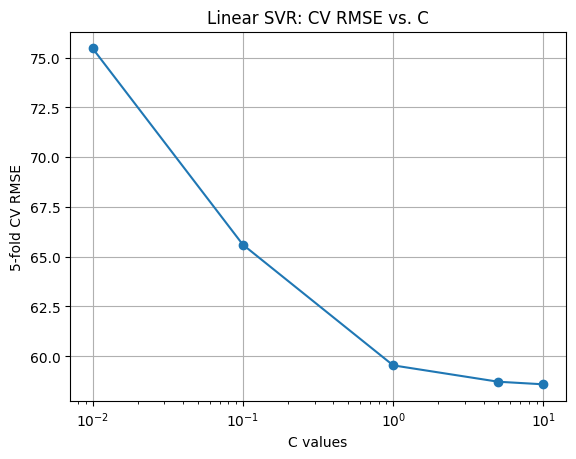

In [7]:
plt.figure()
plt.plot(C_vals_lin, rmse_vals_lin, marker='o')
plt.xscale('log')
plt.xlabel('C values')
plt.ylabel(f'{cv_folds}-fold CV RMSE')
plt.title('Linear SVR: CV RMSE vs. C')
plt.grid(True)
plt.show()

In [8]:
print("Best C (by CV RMSE):", grid_linear.best_params_['svr__C'])

Best C (by CV RMSE): 10


In [9]:
# Prediction with the tuned linear SVR on the test set, compute RMSE, R Square, and MAE to quantify its accuracy,
# then print those test-set performance metrics.


y_pred_lin = grid_linear.predict(X_test)
mse_lin    = mean_squared_error(y_test, y_pred_lin)
rmse_lin   = np.sqrt(mse_lin)
mae_lin    = mean_absolute_error(y_test, y_pred_lin)
r2_lin     = r2_score(y_test, y_pred_lin)

print("\nTest-set performance (Linear SVR):")
print(f"  RMSE: {rmse_lin:.4f}")
print(f"  R Square  : {r2_lin:.4f}")
print(f"  MAE : {mae_lin:.4f}")


Test-set performance (Linear SVR):
  RMSE: 55.3810
  R Square  : 0.4595
  MAE : 21.4257


## Radial Kernel 

In [10]:
#Radial Kernel

# Created a pipeline that standardizes the data and fits an RBF-kernel SVR,
# and define a hyperparameter grid over C and gamma for 5-fold CV tuning

pipe_rbf = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf')
)
param_grid_rbf = {
    'svr__C'    : [0.1, 1, 5, 10],
    'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

In [11]:
# A 5-fold grid search on the RBF SVR pipeline to tune C and gamma,
# evaluating by RMSE, R square, and MAE, and refitting the best model based on RMSE.

grid_rbf = GridSearchCV(
    estimator=pipe_rbf,
    param_grid=param_grid_rbf,
    cv=cv_folds,
    scoring=scoring,
    refit=refit_metric,
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)

In [12]:
#Fitting the radial model
grid_rbf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 5, 10],
                         'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1]},
             refit='rmse',
             scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2',
                      'rmse': 'neg_mean_squared_error'},
             verbose=1)

In [13]:
# CV RMSE vs C for each gamma
res_rbf     = grid_rbf.cv_results_
C_vals      = np.array(res_rbf['param_svr__C'],      dtype=float)
gamma_vals  = np.array(res_rbf['param_svr__gamma'],  dtype=object)
rmse_rbf_cv = np.sqrt(-res_rbf['mean_test_rmse'])

In [14]:
# A DataFrame of CV RMSE scores for each (C, gamma) combination
# and pivot it into a matrix with gamma as rows and C values as columns for visualization.

df_rbf = pd.DataFrame({
    'C':     C_vals,
    'gamma': gamma_vals,
    'RMSE':  rmse_rbf_cv
})
pivot_rbf = df_rbf.pivot(index='gamma', columns='C', values='RMSE')


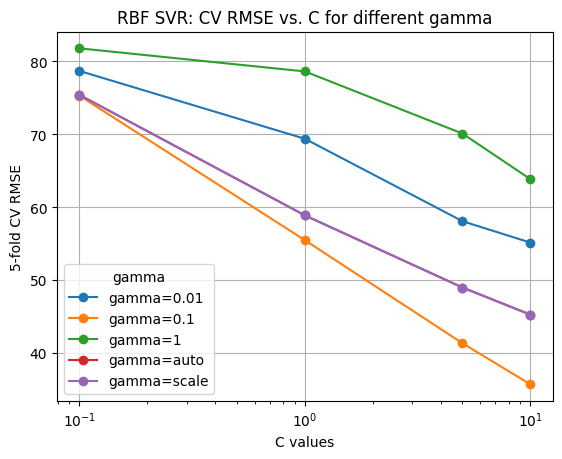

In [21]:

# Plotted the 5-fold CV RMSE against C (log scale) for each Gamma value,
plt.figure()
for gamma in pivot_rbf.index:
    plt.plot(
        pivot_rbf.columns,
        pivot_rbf.loc[gamma],
        marker='o',
        label=f"gamma={gamma}"
    )
plt.xscale('log')
plt.xlabel('C values')
plt.ylabel(f'{cv_folds}-fold CV RMSE')
plt.title('RBF SVR: CV RMSE vs. C for different gamma')
plt.grid(True)
plt.legend(title='gamma')
plt.show()

In [22]:
print("Best params (by CV RMSE):", grid_rbf.best_params_)

Best params (by CV RMSE): {'svr__C': 10, 'svr__gamma': 0.1}


In [23]:
# Test-set evaluation
best_rbf   = grid_rbf.best_estimator_
y_pred_rbf = best_rbf.predict(X_test)
rmse_rbf   = np.sqrt(mean_squared_error(y_test, y_pred_rbf))
r2_rbf     = r2_score(y_test, y_pred_rbf)
mae_rbf    = mean_absolute_error(y_test, y_pred_rbf)

print("\nTest-set performance (RBF SVR):")
print(f"  RMSE: {rmse_rbf:.4f}")
print(f"  R Sqaure  : {r2_rbf:.4f}")
print(f"  MAE : {mae_rbf:.4f}")


Test-set performance (RBF SVR):
  RMSE: 29.9740
  R Sqaure  : 0.8417
  MAE : 9.5529


## Polynomial

In [24]:
#polynomial kernel

# Pipeline that standardizes features and fits a polynomial-kernel SVR,
# grid of C values and polynomial degrees for 5-fold CV tuning 
pipe_poly = make_pipeline(
    StandardScaler(),
    SVR(kernel='poly')
)
param_grid_poly = {
    'svr__C'     : [0.1, 1, 10],
    'svr__degree': [2, 3, 4, 6]
}

In [25]:
# A 5-fold grid search on the polynomial SVR pipeline to tune C and polynomial degree,
# evaluating by RMSE, R square, and MAE, and refitting the best model based on RMSE.

grid_poly = GridSearchCV(
    estimator=pipe_poly,
    param_grid=param_grid_poly,
    cv=cv_folds,
    scoring=scoring,
    refit=refit_metric,
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)

In [26]:
#Fitting a polynomial model
grid_poly.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR(kernel='poly'))]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10], 'svr__degree': [2, 3, 4, 6]},
             refit='rmse',
             scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2',
                      'rmse': 'neg_mean_squared_error'},
             verbose=1)

In [27]:

# CV RMSE vs C for each degree
res_poly      = grid_poly.cv_results_
C_vals_poly   = np.array(res_poly['param_svr__C'],      dtype=float)
deg_vals       = np.array(res_poly['param_svr__degree'], dtype=int)
rmse_poly_cv  = np.sqrt(-res_poly['mean_test_rmse'])

In [28]:
#DataFrame of cross-validated RMSE scores for each (C, degree) pair
df_poly = pd.DataFrame({
    'C'     : C_vals_poly,
    'degree': deg_vals,
    'RMSE'  : rmse_poly_cv
})
pivot_poly = df_poly.pivot(index='degree', columns='C', values='RMSE')

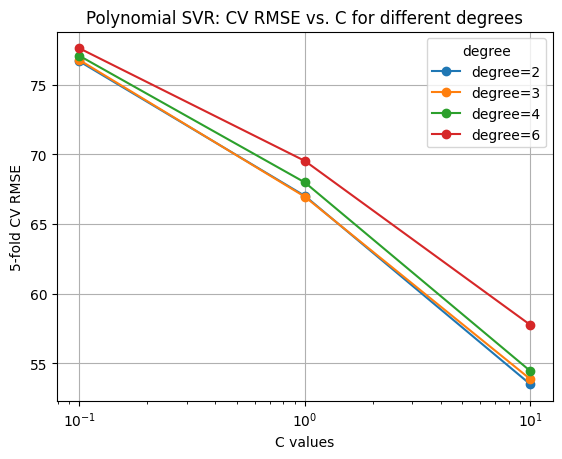

In [29]:
# Plot showing how the 5-fold CV RMSE varies with C (log scale) for each polynomial degree
plt.figure()
for d in pivot_poly.index:
    plt.plot(
        pivot_poly.columns,
        pivot_poly.loc[d],
        marker='o',
        label=f"degree={d}"
    )
plt.xscale('log')
plt.xlabel('C values')
plt.ylabel(f'{cv_folds}-fold CV RMSE')
plt.title('Polynomial SVR: CV RMSE vs. C for different degrees')
plt.grid(True)
plt.legend(title='degree')
plt.show()


In [30]:
print("Best params (by CV RMSE):", grid_poly.best_params_)

Best params (by CV RMSE): {'svr__C': 10, 'svr__degree': 2}


In [31]:
# calculated RMSE, R square, and MAE to evaluate its performance
best_poly    = grid_poly.best_estimator_
y_pred_poly  = best_poly.predict(X_test)
rmse_poly    = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly      = r2_score(y_test, y_pred_poly)
mae_poly     = mean_absolute_error(y_test, y_pred_poly)

print("\nTest-set performance (Poly SVR):")
print(f"  RMSE: {rmse_poly:.4f}")
print(f"  R Sqaure  : {r2_poly:.4f}")
print(f"  MAE : {mae_poly:.4f}")


Test-set performance (Poly SVR):
  RMSE: 49.0354
  R Sqaure  : 0.5763
  MAE : 16.5027


## Results Comparison

In [32]:
#  test metrics for visualization 
test_metrics = {
    'Linear': {'RMSE': rmse_lin, 'R2': r2_lin, 'MAE': mae_lin},
    'RBF'   : {'RMSE': rmse_rbf,'R2': r2_rbf,'MAE': mae_rbf},
    'Poly'  : {'RMSE': rmse_poly,'R2': r2_poly,'MAE': mae_poly},
}

print("\nAll test-set metrics:")
print(test_metrics)


All test-set metrics:
{'Linear': {'RMSE': 55.38100048453137, 'R2': 0.4594901515145283, 'MAE': 21.425738585694308}, 'RBF': {'RMSE': 29.974023527919417, 'R2': 0.8416667578402544, 'MAE': 9.55291292732972}, 'Poly': {'RMSE': 49.03544755146753, 'R2': 0.5762572272157043, 'MAE': 16.50268992102644}}


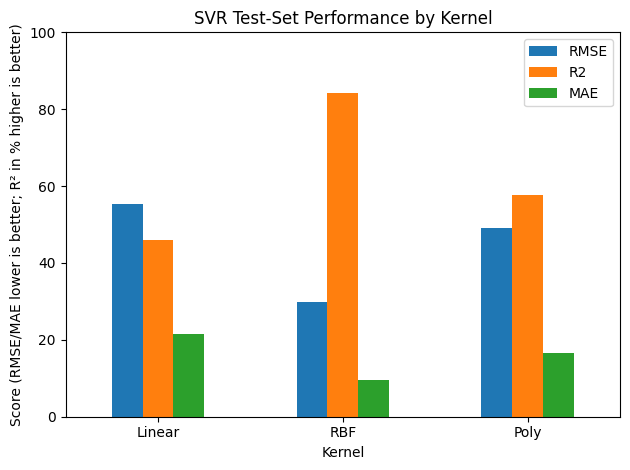

In [33]:
df_metrics = pd.DataFrame(test_metrics).T

df_metrics['R2'] = df_metrics['R2'] * 100

ax = df_metrics.plot(kind='bar', rot=0)
plt.title("SVR Test-Set Performance by Kernel")
plt.xlabel("Kernel")
plt.ylabel("Score (RMSE/MAE lower is better; R² in % higher is better)")

ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()


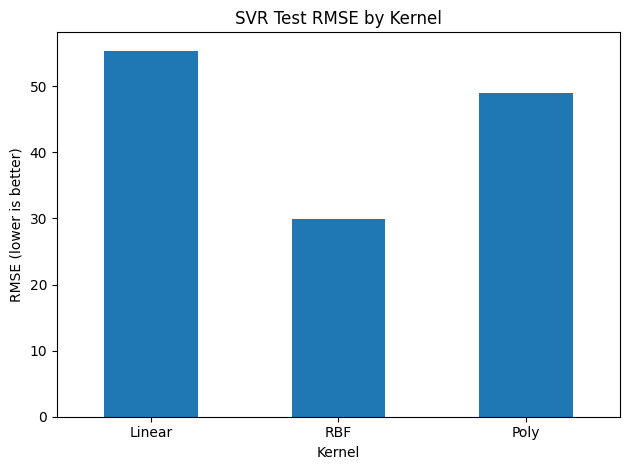

In [34]:
plt.figure()
df_metrics['RMSE'].plot(kind='bar', rot=0)
plt.title("SVR Test RMSE by Kernel")
plt.xlabel("Kernel")
plt.ylabel("RMSE (lower is better)")
plt.tight_layout()
plt.show()

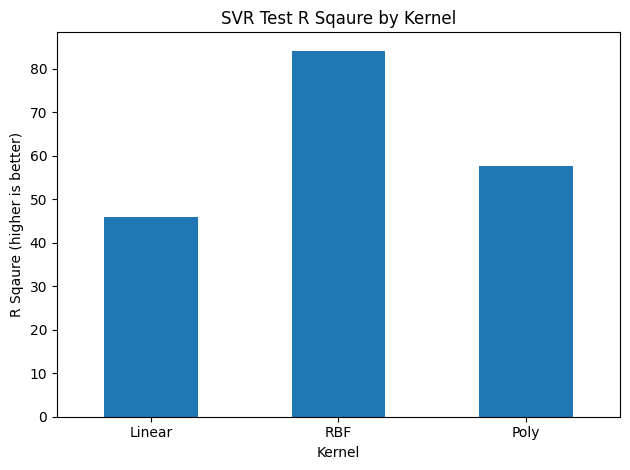

In [35]:
plt.figure()
df_metrics['R2'].plot(kind='bar', rot=0)
plt.title("SVR Test R Sqaure by Kernel")
plt.xlabel("Kernel")
plt.ylabel("R Sqaure (higher is better)")
plt.tight_layout()
plt.show()

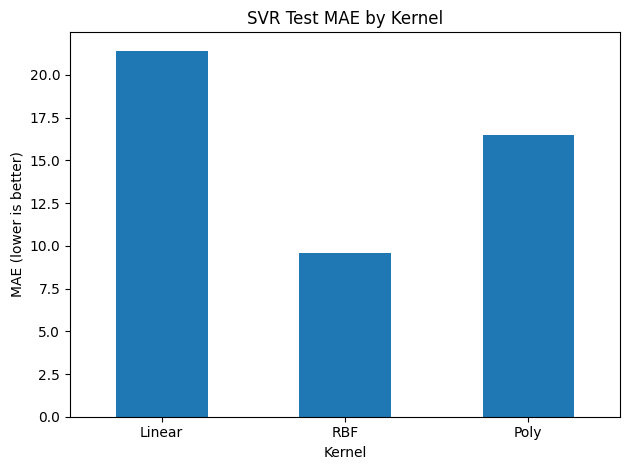

In [36]:
plt.figure()
df_metrics['MAE'].plot(kind='bar', rot=0)
plt.title("SVR Test MAE by Kernel")
plt.xlabel("Kernel")
plt.ylabel("MAE (lower is better)")
plt.tight_layout()
plt.show()

In [37]:
# Generate predictions
y_pred_lin  = grid_linear.best_estimator_.predict(X_test)
y_pred_rbf  = grid_rbf.best_estimator_.predict(X_test)
y_pred_poly = grid_poly.best_estimator_.predict(X_test)

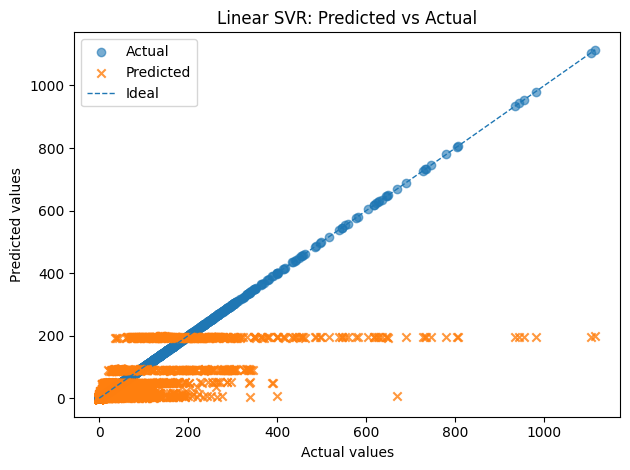

In [38]:
# Linear SVR: Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_test,
            label='Actual', marker='o', alpha=0.6)
plt.scatter(y_test, y_pred_lin,
            label='Predicted', marker='x', alpha=0.8)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         '--', linewidth=1, label='Ideal')
plt.title('Linear SVR: Predicted vs Actual')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()
plt.tight_layout()
plt.show()

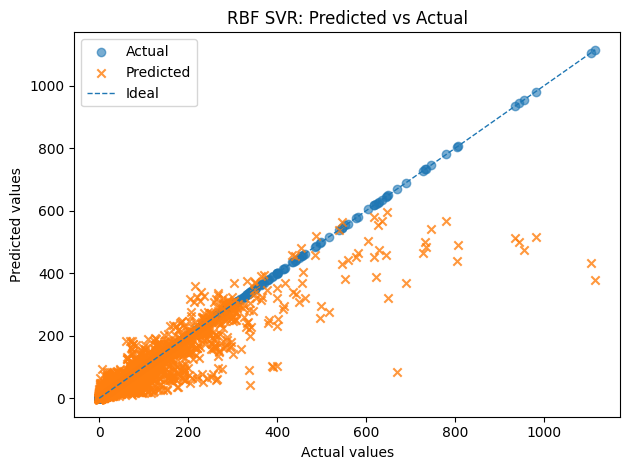

In [39]:
# RBF SVR: Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_test,
            label='Actual', marker='o', alpha=0.6)
plt.scatter(y_test, y_pred_rbf,
            label='Predicted', marker='x', alpha=0.8)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         '--', linewidth=1, label='Ideal')
plt.title('RBF SVR: Predicted vs Actual')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()
plt.tight_layout()
plt.show()


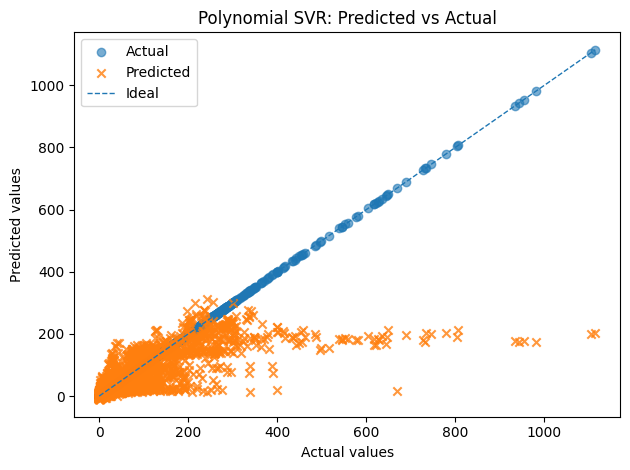

In [40]:

# Polynomial SVR: Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_test,
            label='Actual', marker='o', alpha=0.6)
plt.scatter(y_test, y_pred_poly,
            label='Predicted', marker='x', alpha=0.8)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         '--', linewidth=1, label='Ideal')
plt.title('Polynomial SVR: Predicted vs Actual')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()
plt.tight_layout()
plt.show()